In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


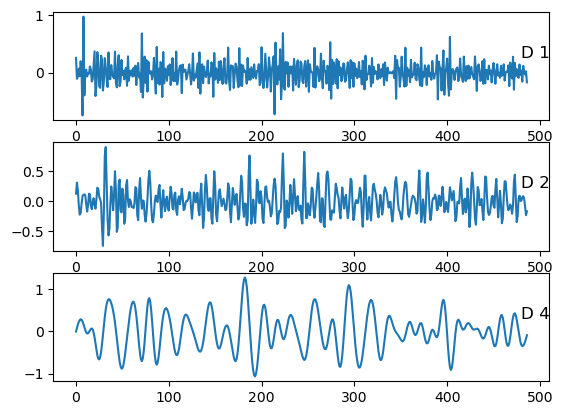

In [2]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('wavelet_coefficients_coif4.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [1,2,4]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [3]:
dataset

,Approximation,D 1,D 2,D 3,D 4
Original Signal,,,,,
-0.92,-0.749018,0.257804,0.125721,0.979909,-0.001386
0.10,-0.669745,-0.106639,0.308835,0.954801,0.084491
0.22,-0.578281,-0.069354,0.182591,0.645153,0.162366
1.02,-0.476245,0.068930,-0.070802,0.162073,0.226204
1.70,-0.365485,-0.061331,-0.221482,-0.326314,0.270423
...,...,...,...,...,...
1.19,-0.931034,0.118670,0.084425,-0.895180,-0.337703
1.69,-0.924637,0.020904,0.045219,-0.655869,-0.301055
1.73,-0.903090,-0.032578,-0.082465,-0.252372,-0.244218


In [4]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg



In [5]:
# load dataset
dataset = read_csv('wavelet_coefficients_coif4.csv')
dataset=dataset.drop(['Approximation', 'D 3'], axis=1)


In [6]:
dataset

,Original Signal,D 1,D 2,D 4
0,-0.92,0.257804,0.125721,-0.001386
1,0.10,-0.106639,0.308835,0.084491
2,0.22,-0.069354,0.182591,0.162366
3,1.02,0.068930,-0.070802,0.226204
4,1.70,-0.061331,-0.221482,0.270423
...,...,...,...,...
482,1.19,0.118670,0.084425,-0.337703
483,1.69,0.020904,0.045219,-0.301055
484,1.73,-0.032578,-0.082465,-0.244218
485,1.81,0.025037,-0.229852,-0.171853


In [8]:
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,3] = encoder.fit_transform(values[:,3])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)
# # drop columns we don't want to predict
# reframed.drop(reframed.columns[[2,3,6]], axis=1, inplace=True)
# print(reframed.head())

     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
1     0.298770   0.582495   0.528277   0.481481  0.478032  0.370808  0.640204   
2     0.478032   0.370808   0.640204   0.592593  0.499121  0.392465  0.563039   
3     0.499121   0.392465   0.563039   0.654321  0.639719  0.472788  0.408155   
4     0.639719   0.472788   0.408155   0.724280  0.759227  0.397125  0.316054   
5     0.759227   0.397125   0.316054   0.751029  0.743410  0.548478  0.331480   
..         ...        ...        ...        ...       ...       ...       ...   
482   0.625659   0.342032   0.493048   0.211934  0.669596  0.501679  0.503036   
483   0.669596   0.501679   0.503036   0.218107  0.757469  0.444892  0.479072   
484   0.757469   0.444892   0.479072   0.242798  0.764499  0.413827  0.401026   
485   0.764499   0.413827   0.401026   0.283951  0.778559  0.447292  0.310938   
486   0.778559   0.447292   0.310938   0.320988  0.773286  0.334535  0.350323   

      var4(t)  
1    0.5925

In [9]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,0.298770,0.582495,0.528277,0.481481,0.478032,0.370808,0.640204,0.592593
2,0.478032,0.370808,0.640204,0.592593,0.499121,0.392465,0.563039,0.654321
3,0.499121,0.392465,0.563039,0.654321,0.639719,0.472788,0.408155,0.724280
4,0.639719,0.472788,0.408155,0.724280,0.759227,0.397125,0.316054,0.751029
5,0.759227,0.397125,0.316054,0.751029,0.743410,0.548478,0.331480,0.769547
...,...,...,...,...,...,...,...,...
482,0.625659,0.342032,0.493048,0.211934,0.669596,0.501679,0.503036,0.218107
483,0.669596,0.501679,0.503036,0.218107,0.757469,0.444892,0.479072,0.242798
484,0.757469,0.444892,0.479072,0.242798,0.764499,0.413827,0.401026,0.283951
485,0.764499,0.413827,0.401026,0.283951,0.778559,0.447292,0.310938,0.320988


In [10]:

# split into train and test sets
values = reframed.values
n_train_hours = 392
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(392, 1, 7) (392,) (94, 1, 7) (94,)


In [11]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=80, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/80
6/6 - 2s - loss: 0.4850 - val_loss: 0.4489 - 2s/epoch - 354ms/step
Epoch 2/80
6/6 - 0s - loss: 0.4217 - val_loss: 0.3821 - 43ms/epoch - 7ms/step
Epoch 3/80
6/6 - 0s - loss: 0.3678 - val_loss: 0.3192 - 39ms/epoch - 6ms/step
Epoch 4/80
6/6 - 0s - loss: 0.3258 - val_loss: 0.2709 - 39ms/epoch - 7ms/step
Epoch 5/80
6/6 - 0s - loss: 0.2937 - val_loss: 0.2365 - 36ms/epoch - 6ms/step
Epoch 6/80
6/6 - 0s - loss: 0.2703 - val_loss: 0.2133 - 38ms/epoch - 6ms/step
Epoch 7/80
6/6 - 0s - loss: 0.2573 - val_loss: 0.2025 - 36ms/epoch - 6ms/step
Epoch 8/80
6/6 - 0s - loss: 0.2503 - val_loss: 0.1978 - 42ms/epoch - 7ms/step
Epoch 9/80
6/6 - 0s - loss: 0.2463 - val_loss: 0.1950 - 40ms/epoch - 7ms/step
Epoch 10/80
6/6 - 0s - loss: 0.2424 - val_loss: 0.1920 - 36ms/epoch - 6ms/step
Epoch 11/80
6/6 - 0s - loss: 0.2380 - val_loss: 0.1883 - 41ms/epoch - 7ms/step
Epoch 12/80
6/6 - 0s - loss: 0.2335 - val_loss: 0.1850 - 40ms/epoch - 7ms/step
Epoch 13/80
6/6 - 0s - loss: 0.2294 - val_loss: 0.1818 - 37ms

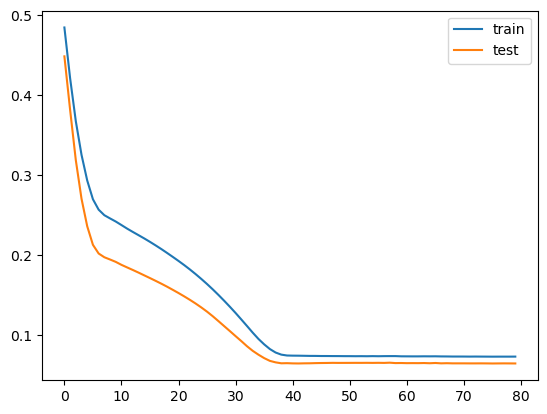

In [12]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [13]:
final_predictions = model.predict(test_X)
print(final_predictions.shape)

3/3 [==============================] - 0s 2ms/step
(94, 1)


In [14]:
train_predictions = model.predict(train_X)
print(train_predictions.shape)

13/13 [==============================] - 0s 2ms/step
(392, 1)


In [15]:
import pandas as pd
pd.DataFrame(train_y).to_csv('actualTrainLSTM .csv', index=False, header=False)
pd.DataFrame(train_predictions).to_csv('predictTrainLSTM .csv', index=False, header=False)
pd.DataFrame(test_y).to_csv('actualTestLSTM.csv', index=False, header=False)
pd.DataFrame(final_predictions).to_csv('predictTestLSTM.csv', index=False, header=False)

In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_evaluation_metrics(y_observed, y_predicted):
     # Convert to NumPy arrays if they are lists
    if isinstance(y_observed, list):
        y_observed = np.array(y_observed)
    if isinstance(y_predicted, list):
        y_predicted = np.array(y_predicted)
        
    metrics = {}

    # Calculate ME (Mean Error)
    metrics['ME'] = np.mean(y_observed - y_predicted)

    # Calculate MAE (Mean Absolute Error)
    metrics['MAE'] = mean_absolute_error(y_observed, y_predicted)

    # Calculate MSE (Mean Squared Error)
    metrics['MSE'] = mean_squared_error(y_observed, y_predicted)

    # Calculate RMSE (Root Mean Squared Error)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])

    # Calculate NRMSE (Normalized Root Mean Squared Error)
    metrics['NRMSE'] = metrics['RMSE'] / (np.max(y_observed) - np.min(y_observed))

    # Calculate PBIAS (Percent Bias)
    metrics['PBIAS'] = np.mean(100 * (y_observed - y_predicted) / np.mean(y_observed))

    # Calculate RSR (Root Mean Square Ratio)
    metrics['RSR'] = metrics['RMSE'] / np.std(y_observed)

    # Calculate rSD (Ratio of the Standard Deviation)
    metrics['rSD'] = np.std(y_observed - y_predicted) / np.std(y_observed)

    # Calculate NSE (Nash-Sutcliffe Efficiency)
    metrics['NSE'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((y_observed - np.mean(y_observed)) ** 2))

    # Calculate mNSE (Modified Nash-Sutcliffe Efficiency)
    metrics['mNSE'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((y_observed - np.mean(y_observed)) ** 2))

    # Calculate rNSE (Relative Nash-Sutcliffe Efficiency)
    metrics['rNSE'] = metrics['NSE'] / np.var(y_observed)

    # Calculate d (Index of Agreement)
    metrics['d'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - np.mean(y_observed)) +
                                                                       np.abs(y_observed - np.mean(y_observed))) ** 2))

    # Calculate md (Modified d Index)
    metrics['md'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - np.mean(y_observed)) +
                                                                         np.abs(y_observed - np.mean(y_observed))) ** 2))

    # Calculate rd (Relative d Index)
    metrics['rd'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - np.mean(y_observed)) +
                                                                         np.abs(y_observed - np.mean(y_observed))) ** 2))

    # Calculate cp (Coefficient of Performance)
    metrics['cp'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - y_observed.mean()) +
                                                                         np.abs(y_observed - y_observed.mean())) ** 2))

    # Calculate r (Index of Agreement)
    metrics['r'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - y_observed.mean()) +
                                                                        np.abs(y_observed - y_observed.mean())) ** 2))

    # Calculate R2 (Coefficient of Determination)
    metrics['R2'] = r2_score(y_observed, y_predicted)

    return metrics


In [17]:
evaluation_metrics = calculate_evaluation_metrics(test_y, final_predictions)
print(evaluation_metrics)

{'ME': 0.0076218946, 'MAE': 0.065028295, 'MSE': 0.007230526, 'RMSE': 0.0850325, 'NRMSE': 0.08925658, 'PBIAS': 1.5075496, 'RSR': 0.36292922, 'rSD': 1.3859445, 'NSE': -179.65863037109375, 'mNSE': -179.65863037109375, 'rNSE': -3272.8197273339397, 'd': 0.4119151830673218, 'md': 0.4119151830673218, 'rd': 0.4119151830673218, 'cp': 0.4119151830673218, 'r': 0.4119151830673218, 'R2': 0.8682823902622887}


In [18]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# Design network
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Fit network
history = model.fit(train_X, train_y, epochs=80, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/80
6/6 - 2s - loss: 0.3154 - val_loss: 0.2406 - 2s/epoch - 357ms/step
Epoch 2/80
6/6 - 0s - loss: 0.2416 - val_loss: 0.1787 - 39ms/epoch - 6ms/step
Epoch 3/80
6/6 - 0s - loss: 0.2130 - val_loss: 0.1642 - 42ms/epoch - 7ms/step
Epoch 4/80
6/6 - 0s - loss: 0.2063 - val_loss: 0.1671 - 36ms/epoch - 6ms/step
Epoch 5/80
6/6 - 0s - loss: 0.2004 - val_loss: 0.1599 - 36ms/epoch - 6ms/step
Epoch 6/80
6/6 - 0s - loss: 0.1897 - val_loss: 0.1481 - 40ms/epoch - 7ms/step
Epoch 7/80
6/6 - 0s - loss: 0.1806 - val_loss: 0.1403 - 36ms/epoch - 6ms/step
Epoch 8/80
6/6 - 0s - loss: 0.1731 - val_loss: 0.1340 - 35ms/epoch - 6ms/step
Epoch 9/80
6/6 - 0s - loss: 0.1649 - val_loss: 0.1267 - 35ms/epoch - 6ms/step
Epoch 10/80
6/6 - 0s - loss: 0.1558 - val_loss: 0.1198 - 35ms/epoch - 6ms/step
Epoch 11/80
6/6 - 0s - loss: 0.1464 - val_loss: 0.1129 - 36ms/epoch - 6ms/step
Epoch 12/80
6/6 - 0s - loss: 0.1369 - val_loss: 0.1051 - 40ms/epoch - 7ms/step
Epoch 13/80
6/6 - 0s - loss: 0.1276 - val_loss: 0.0974 - 39ms

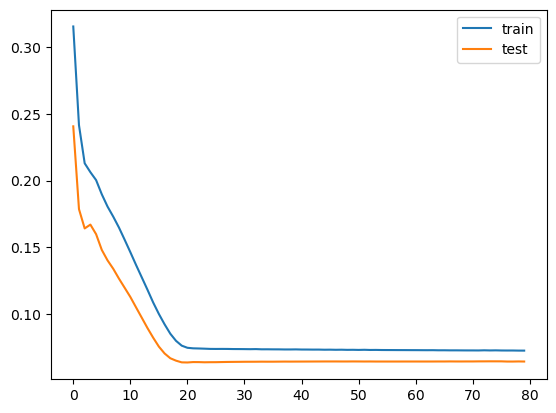

In [19]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [20]:
final_predictions = model.predict(test_X)
print(final_predictions.shape)

3/3 [==============================] - 0s 2ms/step
(94, 1)


In [21]:
train_predictions = model.predict(train_X)
print(train_predictions.shape)

13/13 [==============================] - 0s 1ms/step
(392, 1)


In [22]:
evaluation_metrics = calculate_evaluation_metrics(test_y, final_predictions)
print(evaluation_metrics)

{'ME': 0.0050344197, 'MAE': 0.064584196, 'MSE': 0.007148417, 'RMSE': 0.08454831, 'NRMSE': 0.088748336, 'PBIAS': 0.9957666, 'RSR': 0.36086264, 'rSD': 1.3882079, 'NSE': -180.1927947998047, 'mNSE': -180.1927947998047, 'rNSE': -3282.5505366822813, 'd': 0.41208702325820923, 'md': 0.41208702325820923, 'rd': 0.41208702325820923, 'cp': 0.41208702325820923, 'r': 0.41208702325820923, 'R2': 0.8697781613356717}


In [23]:
pd.DataFrame(train_y).to_csv('actualTrainGRU .csv', index=False, header=False)
pd.DataFrame(train_predictions).to_csv('predictTrainGRU.csv', index=False, header=False)
pd.DataFrame(test_y).to_csv('actualTestGRU.csv', index=False, header=False)
pd.DataFrame(final_predictions).to_csv('predictTestGRU.csv', index=False, header=False)